# Sorani Kurdish data using Pandas plot, take 2

Enabling `mplcairo`, with `raqm`, as the backend for `matplotlib` will allow us to reuse the [Kurdish matplotlib example](https://github.com/enabling-languages/python-i18n/blob/main/notebooks/matplotlib_mplcairo.ipynb) and tackle the missing piece. The previous notebook used a simple Sorani Kurdish bar chart to illustrate how to add complex script text and bidirectional text as a plot title or axes labels amd textual tick labels.

The one missing component was the numeric tick labels. This notebook will look at how you can convert the numeric tick labels from one numeral system to another, applying the converted strings as tick labels.

It is important to note that Python can only identify Western Arabic numerals as intergers or floating point numbers, and only when there is no grouping seperator involved and a period is used as a decimal seperator. All other instances are treated as strings. A number is only a number under very narrow conditions, in all other cases it is necessary to convert a number into a format Python will recognise as either a floating point number or integer.

When plotting data with matplotlib, numeric labels are displayed in a locale invariant form. In order to use locale specific formating of numbers, or to use laternative numeral systmes, it is necessary to write a function that will process the numbers before display, and return a string that can be applied as a specific tick label.

## Setup

First we import the necessary packages. It is important to import _mplcairio_ and set it as a backend for _matplotlib_ before importing _matplotlib.pyplot_. This is a specific macOS concern, but is useful in developing cross-platform code. We will also need to import _import matplotlib.ticker_ inorder to manipulate and tailor the tick labels.

In [123]:
import pandas as pd
import locale, platform
import mplcairo
import matplotlib as mpl
if platform.system() == "Darwin":
    mpl.use("module://mplcairo.macosx")
else:
   mpl.use("module://mplcairo.qt")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata as ud, regex as re


## Helper functions

We will define two helper functions. 

The first, `comvert_digits()` is used to read in non-Western Arabic digits, converting them to floating point numbers or integers as required. This can be used either as a converter when reading data into a dataframe, or as a data cleaning step after reading the data. If using the function for cleanup after reading, it is also necessary to chnage the datatype of the column contents.

`comvert_digits()` takes up to two argumnets:

__s__: This is the string to be converted to a float or int. <br>
__sep__: An optional paramter containing a tuple made up of the grouping seperator and the decimal seperator, the default value is (",", ".").

A float or int is returned.

In [124]:
def convert_digits(s, sep = (",", ".")):
    nd = re.compile(r'^-?\p{Nd}[,.\u066B\u066C\u0020\u2009\p{Nd}]*$')
    tsep, dsep = sep
    if nd.match(s):
        s = s.replace(tsep, "")
        s = ''.join([str(ud.decimal(c, c)) for c in s])
        if dsep in s:
            return float(s.replace(dsep, ".")) if dsep != "." else float(s)
        return int(s)
    return s

seps = ("\u066C", "\u066B")
digitsconv = lambda x: convert_digits(x.replace("-", "٠"), sep = seps)


The second function,`convert_numeral_systems()`, is a generic converter between numeral systems. It strength is in converting floats and integers in Python to other numeral systems. Approximately 60 decimal numeral systems are supported. Algorithmic numeral systems have not been implemented at this point.

`convert_numeral_systems()` has been developed as part of a Python internationalisation framework. It can have up to eight arguments:

__n__: The float, int or string to be converted <br>
__p__: An unused argument, that is swallowed. It is only used with _matplotlib_, where the function needs to accept a tupple as input (n, p). But for converting teh _matplotlib_ tick label, __p__ is not required. <br>
__system_out__: Required function, this is the numeral system we are converting to.<br>
__system_in__: The numeral system of __n__. The most common use of the function is to convert a float or in to another, so default input numeral system is _latn_.<br>
__decimal__: The number of decimal places to use when processing a floating point number. This is only needed when __n__ is a float,  __system_in__ is _latn_, and __sep_in__ is teh default value.<br>
__sep_in__: List containing grouping and decimal seperators used by __n__. Default is `=["", "."],`.<br>
__sep_out__: List containing grouping and decimal seperators used for output.  Default output is `["", "."]`. If a seperator is defined for the target numeral system, the seperator in the data will override this argument.<br>
__scale__: A scaling factor used for _matplotlib_ to manual scale axes tick values. each axis legend should be updated to indicate the scaling.

A _string_ is returned.

In [125]:
def convert_numeral_systems(n, p=None, system_out="", system_in="latn", decimal=2, sep_in=["", "."], sep_out=["", "."], scale=None):
    locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
    decimal_places = decimal
    if system_in == "latn" and sep_in == ["", "."]:
        n = n * scale if scale else n
        format_string = '%0.' + str(decimal_places) + 'f' if type(n) == float else '%d'
        n = locale.format_string(format_string, n, grouping=True, monetary=True)
        n = n.replace(",", "ṯ").replace(".", "ḏ")
        #n = str(n)
    if sep_in[0] in [" ", ",", "٬", "\u2009"]:
        n = n.replace(r'[\u0020,٬\u2009]', "ṯ")
    elif sep_in[0] == ".":
        n = n.replace(".", "ṯ")
    if sep_in[1] in [",", ".", "٫"]:
        n = n.replace(r'[,.٫]', "ḏ")
    data = {
        "adlm" : {'name' : 'Adlam Digits (adlm)', "digits" : "𞥐𞥑𞥒𞥓𞥔𞥕𞥖𞥗𞥘𞥙", "sep_out": [",", "."]},
        "ahom" : {'name' : 'Ahom Digits (ahom)', "digits" : "𑜰𑜱𑜲𑜳𑜴𑜵𑜶𑜷𑜸𑜹"},
        "arab" : {'name' : 'Arabic-Indic Digits (arab)', "digits" : "٠١٢٣٤٥٦٧٨٩"},
        "arabext" : {'name' : 'Extended Arabic-Indic Digits (arabext)', "digits" : "۰۱۲۳۴۵۶۷۸۹", "sep_out_out": ["\u066C", "\u066B"]},
        "bali" : {'name' : 'Balinese Digits (bali)', "digits" : "᭐᭑᭒᭓᭔᭕᭖᭗᭘᭙"},
        "beng" : {'name' : 'Bangla Digits (beng)', "digits" : "০১২৩৪৫৬৭৮৯"},
        "bhks" : {'name' : 'Bhaiksuki  Digits (bhks)', "digits" : "𑱐𑱑𑱒𑱓𑱔𑱕𑱖𑱗𑱘𑱙"},
        "brah" : {'name' : 'Brahmi Digits (brah)', "digits" : "𑁦𑁧𑁨𑁩𑁪𑁫𑁬𑁭𑁮𑁯"},
        "cakm" : {'name' : 'Chakma Digits (cakm)', "digits" : "𑄶𑄷𑄸𑄹𑄺𑄻𑄼𑄽𑄾𑄿"},
        "cham" : {'name' : 'Cham Digits (cham)', "digits" : "꩐꩑꩒꩓꩔꩕꩖꩗꩘꩙"},
        "deva" : {'name' : 'Devanagari Digits (deva)', "digits" : "०१२३४५६७८९"},
        "diak" : {'name' : 'Dhives/Divehi Digits (diak)', "digits" : "𑥐𑥑𑥒𑥓𑥔𑥕𑥖𑥗𑥘𑥙"},
        "fullwide" : {'name' : 'Full-Width Digits (fullwide)', "digits" : "０１２３４５６７８９"},
        "gong" : {'name' : 'Gunjala Gondi digits (gong)', "digits" : "𑶠𑶡𑶢𑶣𑶤𑶥𑶦𑶧𑶨𑶩"},
        "gonm" : {'name' : 'Masaram Gondi digits (gonm)', "digits" : "𑵐𑵑𑵒𑵓𑵔𑵕𑵖𑵗𑵘𑵙"},
        "gujr" : {'name' : 'Gujarati Digits (gujr)', "digits" : "૦૧૨૩૪૫૬૭૮૯"},
        "guru" : {'name' : 'Gurmukhi Digits (guru)', "digits" : "੦੧੨੩੪੫੬੭੮੯"},
        "hmng" : {'name' : 'Pahawh Hmong Digits (hmng)', "digits" : "𖭐𖭑𖭒𖭓𖭔𖭕𖭖𖭗𖭘𖭙"},
        "hmnp" : {'name' : 'Nyiakeng Puachue Hmong Digits (hmnp)', "digits" : "𞅀𞅁𞅂𞅃𞅄𞅅𞅆𞅇𞅈𞅉"},
        "java" : {'name' : 'Javanese Digits (java)', "digits" : "꧐꧑꧒꧓꧔꧕꧖꧗꧘꧙"},
        "kali" : {'name' : 'Kayah Li Digits (kali)', "digits" : "꤀꤁꤂꤃꤄꤅꤆꤇꤈꤉"},
        "khmr" : {'name' : 'Khmer Digits (khmr)', "digits" : "០១២៣៤៥៦៧៨៩"},
        "knda" : {'name' : 'Kannada Digits (knda)', "digits" : "೦೧೨೩೪೫೬೭೮೯"},
        "lana" : {'name' : 'Tai Tham Hora Digits (lana)', "digits" : "᪀᪁᪂᪃᪄᪅᪆᪇᪈᪉"},
        "lanatham" : {'name' : 'Tai Tham Tham Digits (lanatham)', "digits" : "᪐᪑᪒᪓᪔᪕᪖᪗᪘᪙"},
        "laoo" : {'name' : 'Lao Digits (laoo)', "digits" : "໐໑໒໓໔໕໖໗໘໙"},
        "latn" : {'name' : 'Latin Digits (latn)', "digits" : "0123456789"},
        "lepc" : {'name' : 'Lepcha Digits (lepc)', "digits" : "᱀᱁᱂᱃᱄᱅᱆᱇᱈᱉"},
        "limb" : {'name' : 'Limbu Digits (limb)', "digits" : "᥆᥇᥈᥉᥊᥋᥌᥍᥎᥏"},
        "mlym" : {'name' : 'Malayalam Digits (mlym)', "digits" : "൦൧൨൩൪൫൬൭൮൯"},
        "modi" : {'name' : 'Modi Digits (modi)', "digits" : "𑙐𑙑𑙒𑙓𑙔𑙕𑙖𑙗𑙘𑙙"},
        "mong" : {'name' : 'Mongolian Digits (mong)', "digits" : "᠐᠑᠒᠓᠔᠕᠖᠗᠘᠙"},
        "mroo" : {'name' : 'Mro Digits (mroo)', "digits" : "𖩠𖩡𖩢𖩣𖩤𖩥𖩦𖩧𖩨𖩩"},
        "mtei" : {'name' : 'Meetei Mayek Digits (mtei)', "digits" : "꯰꯱꯲꯳꯴꯵꯶꯷꯸꯹"},
        "mymr" : {'name' : 'Myanmar Digits (mymr)', "digits" : "၀၁၂၃၄၅၆၇၈၉", "sep_out": [",", "."]},
        "mymrshan" : {'name' : 'Myanmar Shan Digits (mymrshan)', "digits" : "႐႑႒႓႔႕႖႗႘႙", "sep_out": [",", "."]},
        "mymrtlng" : {'name' : 'Myanmar Tai Laing Digits (mymrtlng)', "digits" : "꧰꧱꧲꧳꧴꧵꧶꧷꧸꧹"},
        "newa" : {'name' : 'Pracalit Digits (newa)', "digits" : "𑑐𑑑𑑒𑑓𑑔𑑕𑑖𑑗𑑘𑑙"},
        "nkoo" : {'name' : "N’Ko Digits (nkoo)", "digits" : "߀߁߂߃߄߅߆߇߈߉"},
        "olck" : {'name' : 'Ol Chiki Digits (olck)', "digits" : "᱐᱑᱒᱓᱔᱕᱖᱗᱘᱙"},
        "orya" : {'name' : 'Odia Digits (orya)', "digits" : "୦୧୨୩୪୫୬୭୮୯"},
        "osma" : {'name' : 'Osmanya Digits (osma)', "digits" : "𐒠𐒡𐒢𐒣𐒤𐒥𐒦𐒧𐒨𐒩"},
        "rohg" : {'name' : 'Hanifi Rohingya digits (rohg)', "digits" : "𐴰𐴱𐴲𐴳𐴴𐴵𐴶𐴷𐴸𐴹"},
        "saur" : {'name' : 'Saurashtra Digits (saur)', "digits" : "꣐꣑꣒꣓꣔꣕꣖꣗꣘꣙"},
        "shrd" : {'name' : 'Sharada Digits (shrd)', "digits" : "𑇐𑇑𑇒𑇓𑇔𑇕𑇖𑇗𑇘𑇙"},
        "sind" : {'name' : 'Khudabadi Digits (sind)', "digits" : "𑋰𑋱𑋲𑋳𑋴𑋵𑋶𑋷𑋸𑋹"},
        "sinh" : {'name' : 'Sinhala Digits (sinh)', "digits" : "෦෧෨෩෪෫෬෭෮෯"},
        "sora" : {'name' : 'Sora Sompeng Digits (sora)', "digits" : "𑃰𑃱𑃲𑃳𑃴𑃵𑃶𑃷𑃸𑃹"},
        "sund" : {'name' : 'Sundanese Digits (sund)', "digits" : "᮰᮱᮲᮳᮴᮵᮶᮷᮸᮹"},
        "takr" : {'name' : 'Takri Digits (takr)', "digits" : "𑛀𑛁𑛂𑛃𑛄𑛅𑛆𑛇𑛈𑛉"},
        "talu" : {'name' : 'New Tai Lue Digits (talu)', "digits" : "᧐᧑᧒᧓᧔᧕᧖᧗᧘᧙"},
        "tamldec" : {'name' : 'Tamil Digits (tamldec)', "digits" : "௦௧௨௩௪௫௬௭௮௯"},
        "tnsa" : {'name' : 'Tangsa Digits (tnsa)', "digits" : "𖫀𖫁𖫂𖫃𖫄𖫅𖫆𖫇𖫈𖫉"},
        "telu" : {'name' : 'Telugu Digits (telu)', "digits" : "౦౧౨౩౪౫౬౭౮౯"},
        "thai" : {'name' : 'Thai Digits (thai)', "digits" : "๐๑๒๓๔๕๖๗๘๙"},
        "tibt" : {'name' : 'Tibetan Digits (tibt)', "digits" : "༠༡༢༣༤༥༦༧༨༩"},
        "tirh" : {'name' : 'Tirhuta Digits (tirh)', "digits" : "𑓐𑓑𑓒𑓓𑓔𑓕𑓖𑓗𑓘𑓙"},
        "vaii" : {'name' : 'Vai Digits (vaii)', "digits" : "꘠꘡꘢꘣꘤꘥꘦꘧꘨꘩"},
        "wara" : {'name' : 'Warang Citi Digits (wara)', "digits" : "𑣠𑣡𑣢𑣣𑣤𑣥𑣦𑣧𑣨𑣩"},
        "wcho" : {'name' : 'Wancho Digits (wcho)', "digits" : "𞋰𞋱𞋲𞋳𞋴𞋵𞋶𞋷𞋸𞋹"}
    }
    try:
        sep = data[system_out]['sep_out']
    except KeyError:
        sep = sep_out
    t = n.maketrans(data[system_in]["digits"], data[system_out]["digits"])
    locale.setlocale(locale.LC_ALL, "")
    return n.translate(t).replace("ṯ", sep[0] ).replace("ḏ", sep[1])

## Process data and plot data

In [126]:
import pandas as pd
conv = {
    'سووریا': digitsconv,
    'عێراق': digitsconv,
    'ئێران': digitsconv,
    'تورکیا': digitsconv,
    'جیھانی': digitsconv
}
df = pd.read_table("../data/demographics.tsv", converters=conv)
df

,---,جیھانی,تورکیا,ئێران,عێراق,سووریا
0,کرمانجی,14419000,7919000,443000,3185000,1661000
1,ئەوانەی بە تورکی دەدوێن,5732000,5732000,0,0,0
2,باشوور,3381000,0,3381000,0,0
3,سۆرانی,1576000,0,502000,567000,0
4,زازایی - دەملی,1125000,1125000,0,0,0
5,زازایی - ئەلڤێکا,184000,179000,0,0,0
6,ڕەوەند,90000,38000,20000,33000,0
7,ھەورامی,54000,0,26000,28000,0
8,شکاکی,49000,23000,26000,0,0
9,کۆی گشتی,26712000,15016000,4398000,3916000,1661000


In [127]:
col_list=["تورکیا" ,"ئێران" ,"عێراق" ,"سووریا"]

total_df = df[col_list].sum(axis=0)
print(total_df)

تورکیا    30032000
ئێران      8796000
عێراق      7729000
سووریا     3322000
dtype: int64


`matplotlib.ticker.FuncFormatter()` takes a function that reads in a tuple. We use a lambda function utilising `convert_numeral_systems()`, with the relevant arguments and values. This will allow us to covnert the tick values into Eastern Arabic numerals, the scale factor allows us to displat the y-axis values in counts of a million.

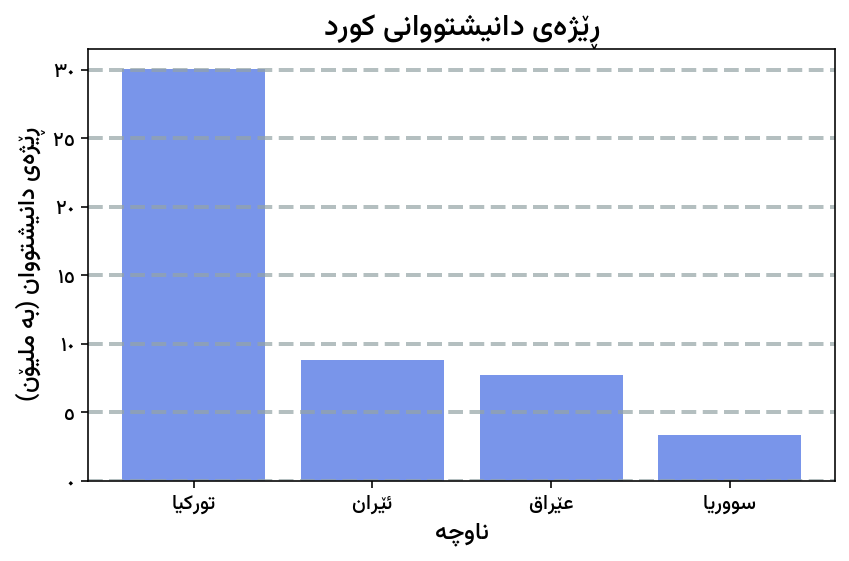

In [128]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.family':'Vazirmatn'})
ax.bar(total_df.index, total_df.values, color='royalblue', alpha=0.7)
ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_xlabel("ناوچە", size=12)
ax.set_ylabel("ڕێژەی دانیشتووان (بە ملیۆن)", size=12)
ax.set_title('ڕێژەی دانیشتووانی کورد', size=15)

DEFAULT_NUMERAL_SYSYEM = "arab"
ns_formatter = ticker.FuncFormatter(lambda x, p: convert_numeral_systems(x, p, system_out=DEFAULT_NUMERAL_SYSYEM, scale=0.000001))
ax.get_yaxis().set_major_formatter(ns_formatter)
plt.tight_layout()
plt.show()

The above steps should work with any complex script language.


__Possible future nehancements:__

Graphs and plots in Arabic script languages are observed in both LTR and RTL layouts. Although given severve software limitations, LTR may be more common. The next step for the adventerous would be to render the above graph in RTL layout.